# Deploying Various MNIST Models on Kubernetes

This notebook will show various rolling deployments of the trained models:
- Single model
- AB Test between 2 models
- Multi-Armed Bandit over 2 models

Using:
- kubeflow
- seldon-core

# Setup

**Ensure you have expose the LoadBalancer external IP**

```bash
$ minikube tunnel
Status:	
	machine: minikube
	pid: 22293
	route: 10.96.0.0/12 -> 192.168.0.5
	minikube: Running
	services: [istio-ingressgateway]
    errors: 
		minikube: no errors
		router: no errors
		loadbalancer emulator: no errors

$ export INGRESS_HOST=$(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')

$ echo $INGRESS_HOST
10.106.254.233
```

In [144]:
%matplotlib inline

import requests
from requests.auth import HTTPBasicAuth
from seldon_core.proto import prediction_pb2
from seldon_core.proto import prediction_pb2_grpc
import tensorflow as tf
import grpc
import json
from matplotlib import pyplot as plt
import numpy as np
from google.protobuf.json_format import MessageToJson


INGRESS_HOST="10.106.254.233"


def rest_request_auth(namespace, deployment, data, username, password):
    url = f"http://{INGRESS_HOST}/seldon/{namespace}/{deployment}/api/v1.0/predictions"
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(url, json=payload, auth=HTTPBasicAuth(username, password))
    print(response.status_code)
    return response.json()   


def send_feedback_rest(namespace, deployment, request, response, reward):
    feedback = {
        "request": request,
        "response": response,
        "reward": reward
    }
    url = f"http://{INGRESS_HOST}/seldon/{namespace}/{deployment}/api/v1.0/feedback"
    response = requests.post(url, json=feedback)
    return response.text


def gen_image(arr):
    plt.figure(figsize=(2,1))
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt


def predict_rest_mnist(namespace='seldon-model', deployment="mnist-classifier", data=None):
    gen_image(data).show()
    data = tf.reshape(data, (1,784))
    features = ["X"+str(i+1) for i in range (0,784)]
    request = {"data":{"names":features,"ndarray":data.numpy().tolist()}}
    predictions = requests.post(f"http://{INGRESS_HOST}/seldon/{namespace}/{deployment}/api/v1.0/predictions",
                             json=request).json()
    print("Response:", predictions)
    print("Prediction:", np.argmax(predictions["data"]["ndarray"]))

    
def predict_grpc_mnist(namespace='seldon-model', deployment="mnist-classifier", data=None):
    gen_image(data).show()
    data = tf.reshape(data, (784))
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    request = prediction_pb2.SeldonMessage(data=datadef)
    channel = grpc.insecure_channel(f"{INGRESS_HOST}:80")
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deployment), ('namespace',namespace)]
    response = stub.Predict(request=request,metadata=metadata)
    predictions = MessageToJson(response) # str
    predictions = json.loads(predictions)
    print("Response:", predictions)
    print("Prediction:", np.argmax(predictions["data"]["tensor"]["values"]))

In [145]:
with open("payload.json") as f:
    data = json.load(f)
data = np.array(data["data"]["ndarray"])
print(data.shape)

(1, 784)


# Deploy Single Tensorflow Model

In [146]:
!kubectl apply -f components_spec/serving_model.yml

seldondeployment.machinelearning.seldon.io/mnist-classifier created


In [152]:
!kubectl get pods -n seldon-model

NAME                                                            READY   STATUS    RESTARTS   AGE
mnist-classifier-mnist-classifier-0-tf-model-587554bc88-cmzct   3/3     Running   0          29s


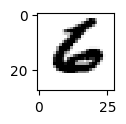

Response: {'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'ndarray': [[3.195868492126465, -7.452676296234131, 5.716387748718262, -3.8307650089263916, 0.4197545349597931, 0.11819814890623093, 11.687692642211914, -5.1460957527160645, -0.1615648865699768, -1.3310203552246094]]}, 'meta': {'requestPath': {'tf-model': 'hoangph3/tf_mnist_serving:v0.0.1'}}}
Prediction: 6


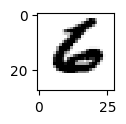

Response: {'meta': {'requestPath': {'tf-model': 'hoangph3/tf_mnist_serving:v0.0.1'}}, 'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'tensor': {'shape': [1, 10], 'values': [3.195868492126465, -7.452676296234131, 5.716387748718262, -3.8307650089263916, 0.4197545349597931, 0.11819814890623093, 11.687692642211914, -5.1460957527160645, -0.1615648865699768, -1.3310203552246094]}}}
Prediction: 6


(None, None)

In [155]:
predict_rest_mnist(data=data), predict_grpc_mnist(data=data)

In [156]:
!kubectl delete -f components_spec/serving_model.yml

seldondeployment.machinelearning.seldon.io "mnist-classifier" deleted


# Rolling update to AB Test
 Run an AB Test between 2 models:
  * Tensorflow neural network model
  * Scikit-learn random forest.

In [157]:
!kubectl apply -f components_spec/ab_test_sklearn_tensorflow.yml

seldondeployment.machinelearning.seldon.io/mnist-classifier created


In [160]:
!kubectl get pods -n seldon-model

NAME                                                              READY   STATUS    RESTARTS   AGE
mnist-classifier-mnist-classifier-0-tf-model-sk-model-88dczl9wz   4/4     Running   0          27s


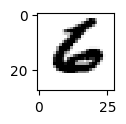

Response: {'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'ndarray': [[3.195868492126465, -7.452676296234131, 5.716387748718262, -3.8307650089263916, 0.4197545349597931, 0.11819814890623093, 11.687692642211914, -5.1460957527160645, -0.1615648865699768, -1.3310203552246094]]}, 'meta': {'requestPath': {'tf-model': 'hoangph3/tf_mnist_serving:v0.0.1'}}}
Prediction: 6


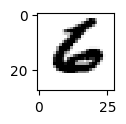

Response: {'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'ndarray': [[0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.2, 0.3333333333333333, 0.06666666666666667, 0.06666666666666667, 0.0, 0.06666666666666667]]}, 'meta': {'requestPath': {'sk-model': 'hoangph3/sk_mnist_serving:v0.0.1'}}}
Prediction: 5


(None, None)

In [162]:
predict_rest_mnist(data=data), predict_rest_mnist(data=data)

In [164]:
!kubectl delete -f components_spec/ab_test_sklearn_tensorflow.yml

seldondeployment.machinelearning.seldon.io "mnist-classifier" deleted


# Rolling Update to Canary
 

Firstly, we will create a Seldon Deployment with a model image `hoangph3/tf_mnist_serving:v0.0.1`. This deployment is named `example`.

```yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: example
  namespace: seldon-model
spec:
  name: canary-example
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: hoangph3/tf_mnist_serving:v0.0.1
          imagePullPolicy: IfNotPresent
          name: classifier
          volumeMounts:
          - mountPath: "/models"
            name: persistent-storage
        terminationGracePeriodSeconds: 1
        volumes:
        - name: persistent-storage
          persistentVolumeClaim:
            claimName: nfs-1
    graph:
      children: []
      endpoint:
        type: REST
      name: classifier
      type: MODEL
    name: main
    replicas: 1
```

In [166]:
!kubectl apply -f components_spec/main_model.yml

seldondeployment.machinelearning.seldon.io/example unchanged


In [172]:
!kubectl get pods -n seldon-model

NAME                                        READY   STATUS    RESTARTS   AGE
example-main-0-classifier-855b658b6-pnzwn   3/3     Running   0          36s


In [173]:
from seldon_core.seldon_client import SeldonClient
sc = SeldonClient(
    deployment_name="example", namespace="seldon-model", gateway_endpoint=f"{INGRESS_HOST}:80", gateway='istio'
)
r = sc.predict(transport="rest", data=data)
assert r.success == True
print(r.response)

{'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'tensor': {'shape': [1, 10], 'values': [3.195868492126465, -7.452676296234131, 5.716387748718262, -3.8307650089263916, 0.4197545349597931, 0.11819814890623093, 11.687692642211914, -5.1460957527160645, -0.1615648865699768, -1.3310203552246094]}}, 'meta': {'requestPath': {'classifier': 'hoangph3/tf_mnist_serving:v0.0.1'}}}


Now we will launch the canary
```yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: example
  namespace: seldon-model
spec:
  name: canary-example
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: hoangph3/tf_mnist_serving:v0.0.1
          imagePullPolicy: IfNotPresent
          name: classifier
          volumeMounts:
          - mountPath: "/models"
            name: persistent-storage
        terminationGracePeriodSeconds: 1
        volumes:
        - name: persistent-storage
          persistentVolumeClaim:
            claimName: nfs-1
    graph:
      children: []
      endpoint:
        type: REST
      name: classifier
      type: MODEL
    name: main
    replicas: 1
    traffic: 75
  
  - componentSpecs:
    - spec:
        containers:
        - image: hoangph3/sk_mnist_serving:v0.0.1
          imagePullPolicy: IfNotPresent
          name: classifier
          volumeMounts:
          - mountPath: "/models"
            name: persistent-storage
        terminationGracePeriodSeconds: 1
        volumes:
        - name: persistent-storage
          persistentVolumeClaim:
            claimName: nfs-1
    graph:
      children: []
      endpoint:
        type: REST
      name: classifier
      type: MODEL
    name: canary
    replicas: 1
    traffic: 25
```

In [174]:
!kubectl apply -f components_spec/canary_model.yml

seldondeployment.machinelearning.seldon.io/example configured


In [181]:
!kubectl get pods -n seldon-model

NAME                                           READY   STATUS    RESTARTS   AGE
example-canary-0-classifier-5c4b49784f-m2cbj   1/3     Running   0          24s
example-main-0-classifier-855b658b6-pnzwn      3/3     Running   0          72s


In [183]:
from collections import defaultdict

counts = defaultdict(int)

for _ in range(100):
    target_model = sc.predict(transport="rest", data=data).response["meta"]["requestPath"]["classifier"]
    counts[target_model] +=1 

print(dict(counts))

{'hoangph3/sk_mnist_serving:v0.0.1': 27, 'hoangph3/tf_mnist_serving:v0.0.1': 73}


In [187]:
!kubectl delete -f components_spec/canary_model.yml

Error from server (NotFound): error when deleting "components_spec/canary_model.yml": seldondeployments.machinelearning.seldon.io "example" not found


# Rolling Update to Multi-Armed Bandit
Run a epsilon-greedy multi-armed bandit over 2 models:
  * Tensorflow neural network model
  * Scikit-learn random forest model

In [350]:
!kubectl apply -f components_spec/multi_arm_epsilon_greedy.yml

seldondeployment.machinelearning.seldon.io/mnist-classifier unchanged


In [351]:
!kubectl get pods -n seldon-model

NAME                                                              READY   STATUS    RESTARTS   AGE
mnist-classifier-mnist-classifier-0-tf-model-sk-model-eg-rkplqk   5/5     Running   0          6m49s


In [352]:
from collections import defaultdict

sc = SeldonClient(
    deployment_name="mnist-classifier", namespace="seldon-model",
    gateway_endpoint=f"{INGRESS_HOST}:80", gateway='istio'
)

r = sc.predict(transport="rest", data=data)
assert r.success == True
print(r.response)

{'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'tensor': {'shape': [1, 10], 'values': [0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.2, 0.3333333333333333, 0.06666666666666667, 0.06666666666666667, 0, 0.06666666666666667]}}, 'meta': {'requestPath': {'sk-model': 'hoangph3/sk_mnist_serving:v0.0.1'}, 'routing': {'eg-router': 0, 'sk-model': -1}}}


In [353]:
!kubectl delete -f components_spec/multi_arm_epsilon_greedy.yml

seldondeployment.machinelearning.seldon.io "mnist-classifier" deleted


# (Optional) Shadow 

Shadow deployment allows you to test new models in a production setting and with production traffic and anlalyse how they perform before putting them live.

In [388]:
!kubectl apply -f components_spec/shadow_model.yml

seldondeployment.machinelearning.seldon.io/example created


In [391]:
!kubectl get pods -n seldon-model

NAME                                            READY   STATUS    RESTARTS   AGE
example-default-0-classifier-66cf6c7658-pbwqr   3/3     Running   0          30s
example-shadow-0-classifier-86c9bc99f4-xqqtl    3/3     Running   0          30s


In [392]:
from collections import defaultdict

sc = SeldonClient(
    deployment_name="example", namespace="seldon-model", gateway_endpoint=INGRESS_HOST, gateway="istio"
)

counts = defaultdict(int)
for _ in range(100):
    target_model = sc.predict(transport="rest", data=data).response["meta"]["requestPath"]["classifier"]
    counts[target_model] +=1 
print(dict(counts))

{'hoangph3/tf_mnist_serving:v0.0.1': 100}


In [395]:
!kubectl logs -n seldon-model example-default-0-classifier-66cf6c7658-pbwqr classifier | grep predict | wc -l

101


In [396]:
!kubectl logs -n seldon-model example-shadow-0-classifier-86c9bc99f4-xqqtl classifier | grep predict | wc -l

101


We have just test a new model with production traffic but without affecting the live deployment.

In [397]:
!kubectl delete -f components_spec/shadow_model.yml

seldondeployment.machinelearning.seldon.io "example" deleted
